In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from collections import defaultdict
from tqdm.keras import TqdmCallback
from sklearn.metrics import classification_report
import shutil
import json
import zipfile


gpus = tf.config.list_physical_devices("GPU")
print("GPUs:", gpus)

2026-01-06 15:41:03.170972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767714063.364249      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767714063.418246      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767714063.892878      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767714063.892920      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767714063.892922      55 computation_placer.cc:177] computation placer alr

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
DATA_DIR = "/kaggle/input/vegetable-image-dataset/Vegetable Images/"
TRAIN_DIR = f"{DATA_DIR}/train"
VAL_DIR   = f"{DATA_DIR}/validation"
TEST_DIR  = f"{DATA_DIR}/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [3]:
image_size_counts = defaultdict(int)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for fname in filenames:
        path = os.path.join(dirname, fname)
        with Image.open(path) as img:
            size = img.size  # (width, height)
            image_size_counts[size] += 1

image_size_dict = dict(image_size_counts)
image_size_dict

{(224, 224): 20991,
 (224, 187): 1,
 (224, 223): 1,
 (224, 207): 1,
 (224, 210): 1,
 (224, 211): 1,
 (224, 198): 1,
 (224, 193): 1,
 (224, 200): 1,
 (224, 205): 1}

(224, 224, 3)


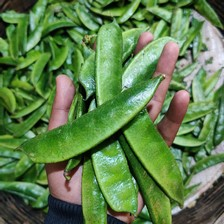

In [4]:
sample = load_img("/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Bean/0001.jpg")
print(np.array(sample).shape)
sample

## Preprocessing

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode="int",
    shuffle=False
)


Found 15000 files belonging to 15 classes.


I0000 00:00:1767714258.299772      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767714258.303612      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)

print("num_classes:", num_classes)
print("class_names:", class_names)

num_classes: 15
class_names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


## Baseline CNN

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [8]:
# Efficient Net Baseline
inputs = tf.keras.Input(shape=(224, 224, 3), name="image")

# EfficientNet preprocessing
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=x
)
base.trainable = False 

x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(base.output)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = tf.keras.Model(inputs, outputs, name="effnetb0_basic")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

Model: "effnetb0_basic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=10,
                    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10


I0000 00:00:1767714272.126355     135 service.cc:152] XLA service 0x7934c0114ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767714272.126401     135 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767714272.126408     135 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767714274.217320     135 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-06 15:44:40.755893: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:44:40.900154: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:44:41.235368: E external/local_xl

467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8745 - loss: 0.6423

2026-01-06 15:45:09.156589: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:45:09.299574: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:45:09.626982: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:45:09.768410: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:45:10.484094: E external/local_xla/xla/stream_

469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 87ms/step - accuracy: 0.8751 - loss: 0.6398 - val_accuracy: 0.9970 - val_loss: 0.0355
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9953 - loss: 0.0369 - val_accuracy: 0.9983 - val_loss: 0.0159
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9983 - loss: 0.0168 - val_accuracy: 0.9990 - val_loss: 0.0099
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9986 - loss: 0.0107 - val_accuracy: 0.9990 - val_loss: 0.0071
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9992 - loss: 0.0082 - val_accuracy: 0.9990 - val_loss: 0.0056
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9990 - val_loss: 0.0044
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9999 - loss: 0.0043 - val_accuracy: 0.9990 - val_loss: 0.0039
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accurac

In [11]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9997 - loss: 0.0019
Validation accuracy: 0.9993


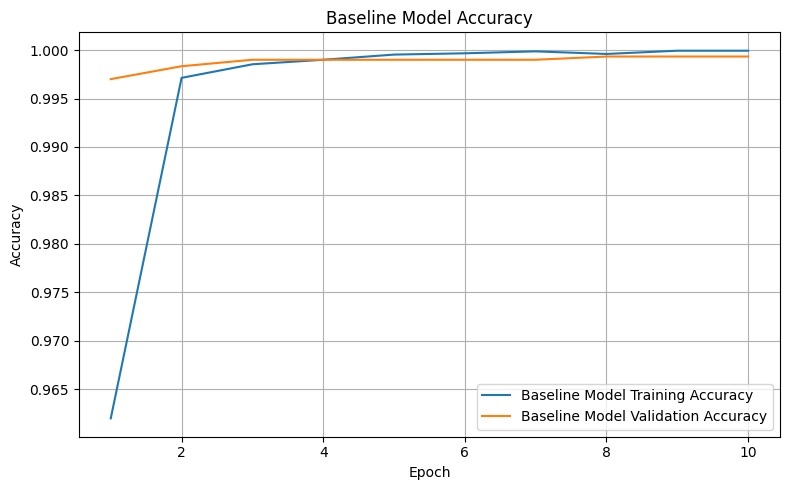

In [12]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, label="Baseline Model Training Accuracy")
plt.plot(epochs, val_acc, label="Baseline Model Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9990


In [15]:
# Collect predictions and true labels
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Bean     1.0000    1.0000    1.0000       200
Bitter_Gourd     1.0000    0.9950    0.9975       200
Bottle_Gourd     1.0000    1.0000    1.0000       200
     Brinjal     1.0000    1.0000    1.0000       200
    Broccoli     1.0000    1.0000    1.0000       200
     Cabbage     1.0000    0.9950    0.9975       200
    Capsicum     1.0000    1.0000    1.0000       200
      Carrot     1.0000    1.0000    1.0000       200
 Cauliflower     0.9901    1.0000    0.9950       200
    Cucumber     0.9950    1.0000    0.9975       200
      Papaya     1.0000    1.0000    1.0000       200
      Potato     1.0000    1.0000    1.0000       200
     Pumpkin     1.0000    0.9950    0.9975       200
      Radish     1.0000    1.0000    1.0000       200
      Tomato     1.0000    1.0000    1.0000       200

    accuracy                         0.9990      3000
   macro avg     0.9990    0.9990    0.9990      3000
weighted avg     0.9990   

## Augmentation

No need for learning rate calibration or dropout as accuracy is already >0.9

In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3), name="image")

augment = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ],
    name="augment",
)

x = augment(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
)
base.trainable = False

x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(x)

outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)


In [17]:
model_aug = tf.keras.Model(inputs, outputs, name="effnetb0_aug")

model_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model_aug.summary()

Model: "effnetb0_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [18]:

history = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10


E0000 00:00:1767714643.555391      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/effnetb0_aug_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 93ms/step - accuracy: 0.8636 - loss: 0.7010 - val_accuracy: 0.9957 - val_loss: 0.0389
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9949 - loss: 0.0446 - val_accuracy: 0.9973 - val_loss: 0.0189
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9965 - loss: 0.0246 - val_accuracy: 0.9977 - val_loss: 0.0119
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9976 - loss: 0.0155 - val_accuracy: 0.9987 - val_loss: 0.0085
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9987 - loss: 0.0105 - val_accuracy: 0.9983 - val_loss: 0.0066
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9987 - loss: 0.0091 - val_accuracy: 0.9990 - val_loss: 0.0050
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9995 - loss: 0.0059 - val_accuracy: 0.9990 - val_loss: 0.0043
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9991 - loss: 0.0060 - val_accurac

In [19]:
val_loss, val_acc = model_aug.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9996 - loss: 0.0019
Validation accuracy: 0.9990


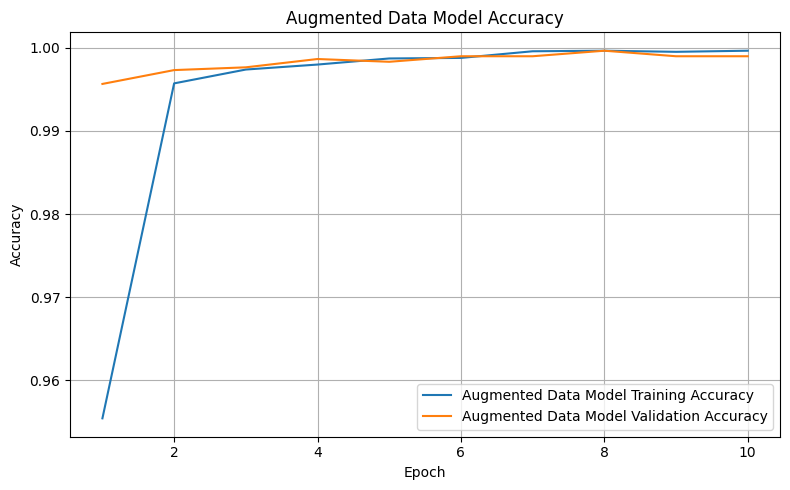

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, label="Augmented Data Model Training Accuracy")
plt.plot(epochs, val_acc, label="Augmented Data Model Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Augmented Data Model Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
test_loss, test_acc = model_aug.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9993


## Model Diagnostics

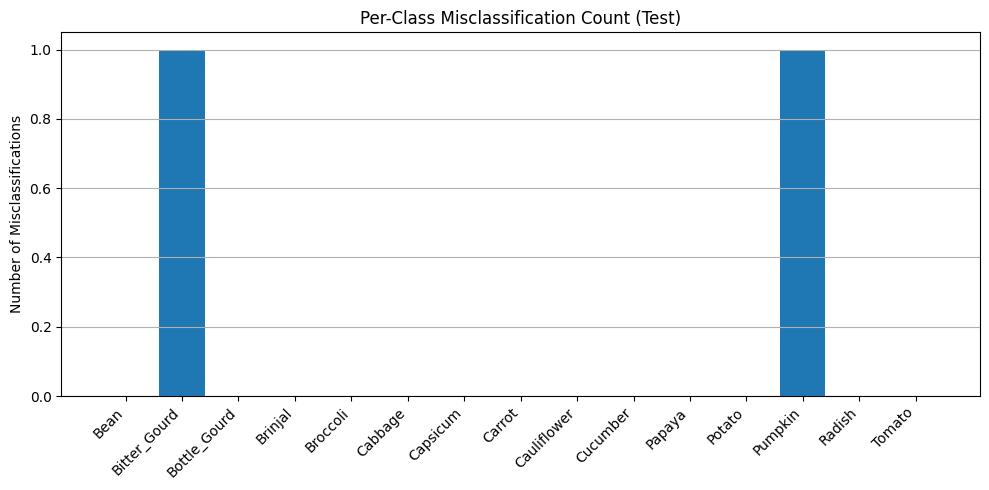

In [22]:
class_wrong = defaultdict(int)
class_total = defaultdict(int)

for xb, yb in test_ds:
    probs = model_aug.predict(xb, verbose=0)
    preds = np.argmax(probs, axis=1)

    for i in range(len(yb)):
        cls = class_names[int(yb[i])]
        class_total[cls] += 1
        if preds[i] != yb[i]:
            class_wrong[cls] += 1

misclass_counts = [class_wrong[c] for c in class_names]

plt.figure(figsize=(10, 5))
plt.bar(class_names, misclass_counts)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Misclassifications")
plt.title("Per-Class Misclassification Count (Test)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [23]:
# Examples
correct_images = []
correct_true = []
correct_pred = []
correct_conf = []

mis_images = []
mis_true = []
mis_pred = []
mis_conf = []

for xb, yb in test_ds:
    probs = model_aug.predict(xb, verbose=0)
    preds = np.argmax(probs, axis=1)
    confs = np.max(probs, axis=1)

    for i in range(len(yb)):
        img = xb[i].numpy()
        true_cls = class_names[int(yb[i])]
        pred_cls = class_names[int(preds[i])]
        conf = confs[i]

        if preds[i] == yb[i]:
            if len(correct_images) < 5:
                correct_images.append(img)
                correct_true.append(true_cls)
                correct_pred.append(pred_cls)
                correct_conf.append(conf)
        else:
            if len(mis_images) < 5:
                mis_images.append(img)
                mis_true.append(true_cls)
                mis_pred.append(pred_cls)
                mis_conf.append(conf)

    if len(correct_images) >= 5 and len(mis_images) >= 5:
        break


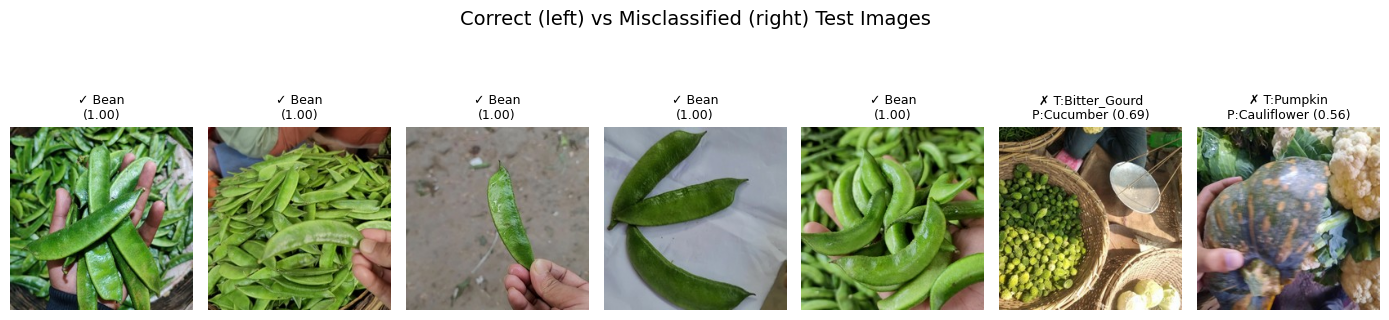

In [24]:
total = len(correct_images) + len(mis_images)
plt.figure(figsize=(14, 4))

idx = 1

for i in range(len(correct_images)):
    plt.subplot(1, total, idx)
    plt.imshow(correct_images[i].astype("uint8"))
    plt.title(
        f"✓ {correct_true[i]}\n({correct_conf[i]:.2f})",
        fontsize=9
    )
    plt.axis("off")
    idx += 1

for i in range(len(mis_images)):
    plt.subplot(1, total, idx)
    plt.imshow(mis_images[i].astype("uint8"))
    plt.title(
        f"✗ T:{mis_true[i]}\nP:{mis_pred[i]} ({mis_conf[i]:.2f})",
        fontsize=9
    )
    plt.axis("off")
    idx += 1

plt.suptitle("Correct (left) vs Misclassified (right) Test Images", fontsize=14)
plt.tight_layout()
plt.show()


## Exporting

In [25]:
for layer in model_aug.layers:
    print(layer.name, type(layer))


image <class 'keras.src.layers.core.input_layer.InputLayer'>
augment <class 'keras.src.models.sequential.Sequential'>
efficientnetb0 <class 'keras.src.models.functional.Functional'>
gap <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
pred <class 'keras.src.layers.core.dense.Dense'>


In [26]:
base = model_aug.get_layer("efficientnetb0")   # backbone
gap  = model_aug.get_layer("gap")              # pooling
pred = model_aug.get_layer("pred")             # classifier head

# remove augmentation
inputs = tf.keras.Input(shape=(224, 224, 3), name="image")

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base(x, training=False)
x = gap(x)
outputs = pred(x)

serving_model = tf.keras.Model(inputs, outputs, name="vegetable_model_serving")
serving_model.summary()

Model: "vegetable_model_serving"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [27]:
export_path = "/kaggle/working/vegetable-model/1"
serving_model.export(export_path)
print("SavedModel exported to:", export_path)

INFO:tensorflow:Assets written to: /kaggle/working/vegetable-model/1/assets


INFO:tensorflow:Assets written to: /kaggle/working/vegetable-model/1/assets


Saved artifact at '/kaggle/working/vegetable-model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  133267378524368: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133267378525136: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133267904818896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133267904815824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133267904818128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133267904813328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133267904816976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133267904817744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133267904815056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133267904817552: TensorSpec(shape=(), dtype=tf.resource

In [28]:
loaded = tf.saved_model.load(export_path)
infer = loaded.signatures["serving_default"]

print("Input signature:", infer.structured_input_signature)
print("Output keys:", infer.structured_outputs)

Input signature: ((), {'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image')})
Output keys: {'output_0': TensorSpec(shape=(None, 15), dtype=tf.float32, name='output_0')}


In [29]:

src_dir = "/kaggle/working/vegetable-model"
zip_path = "/kaggle/working/vegetable-model.zip"

shutil.make_archive(
    base_name=zip_path.replace(".zip", ""),
    format="zip",
    root_dir=src_dir
)

print("Zipped model saved to:", zip_path)


Zipped model saved to: /kaggle/working/vegetable-model.zip


In [30]:
class_map_path = "/kaggle/working/class_names.json"
with open(class_map_path, "w") as f:
    json.dump(class_names, f, indent=2)

# Append to existing zip
with zipfile.ZipFile(zip_path, "a") as z:
    z.write(class_map_path, arcname="class_names.json")

print("Added class_names.json to zip")

Added class_names.json to zip


In [31]:
!ls -lh /kaggle/working

total 29M
-rw-r--r-- 1 root root  206 Jan  6 15:58 class_names.json
drwxr-xr-x 3 root root 4.0K Jan  6 15:58 vegetable-model
-rw-r--r-- 1 root root  29M Jan  6 15:58 vegetable-model.zip
